script
- selects the triplets used for the first individual differences in object representation study
- saves the triplet ids and the required file paths of the images to be used in the study html and js

In [24]:
import os
import re

from functools import partial

import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
import utils as ut

In [5]:
df_items_delta = pd.read_csv("data/triplets-delta.csv")

In [35]:
n_informative_trials = 440
n_practice_trials = 5
seed = 3832

my_cols = ["triplet_id", "id_lo", "id_mid","id_hi", "delta", "prop_max"]

# 1. triplets most informative given the models
df_triplets_study_delta = df_items_delta.query("n_per_triplet >= 100")[my_cols].drop_duplicates().sort_values(
    "delta", ascending=False).head(int(n_informative_trials/2))
df_triplets_remaining = pd.merge(df_items_delta, df_triplets_study_delta[["triplet_id", "delta"]], how="left", on="triplet_id", suffixes=("", "_y"))
df_triplets_remaining = df_triplets_remaining.query("delta_y.isna()").drop(columns=["delta_y"])

# 2. triplets most disagreed upon from the participants
#df_triplets_study_disagree = df_triplets_remaining.query(
#    "n_per_triplet >= 100 & delta >= 0.035"
#)[["delta", "prop_max", "triplet_id", "id_lo", "id_mid","id_hi"]].drop_duplicates().sort_values(
#    "prop_max").head(int(n_informative_trials/2))

# 3. random selection amongst the rest with constraint that delta >= 0
df_triplets_study_random = df_triplets_remaining.query("delta >= 0").sample(n=int(n_informative_trials/2), random_state=seed)

df_triplets_study = pd.concat([df_triplets_study_delta, df_triplets_study_random])
df_triplets_study = df_triplets_study[my_cols].drop_duplicates().head(n_informative_trials)

df_triplets_study = df_triplets_study.sample(frac=1).reset_index(drop=True)

df_triplets_practice = df_items_delta.query("delta <= 0.05")[["delta", "triplet_id", "id_lo", "id_mid","id_hi"]].drop_duplicates(
    ).sort_values("delta", ascending=False).head(n_practice_trials).sample(frac=1).reset_index(drop=True)

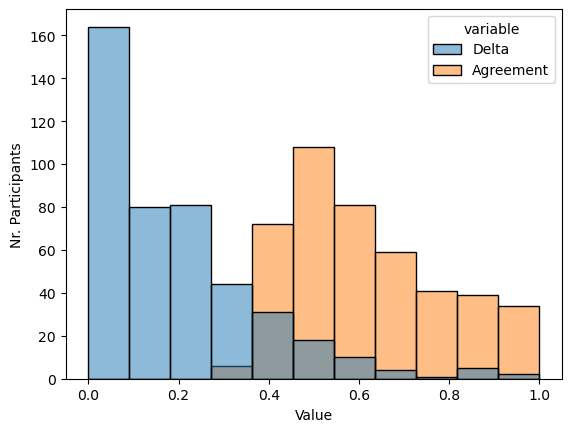

In [27]:
sns.histplot(data=df_triplets_study.rename(columns={'delta': 'Delta', "prop_max":"Agreement"}).melt(value_vars=["Delta", "Agreement"]), x="value", hue="variable")
plt.xlabel("Value")
_ = plt.ylabel("Nr. Participants")

In [28]:
l_concepts = os.listdir("data/images/")
l_m = [re.match("^[a-z]", l_concepts[i]) for i in range(0, len(l_concepts))]
l_filter = [l_m[i] != None for i in range(0, len(l_concepts))]
l_concepts_filtered = [value for value, flag in zip(l_concepts, l_filter) if flag]
f_partial = partial(ut.extract_image, l_concepts_filtered)

In [30]:
l_all_study = []
l_all_ids_study = []
l_all_triplets_study = []
for i, row in df_triplets_study.iterrows():
    current_ids = row[["id_lo", "id_mid", "id_hi"]]
    l_current_ids = list(current_ids.values.reshape(-1))
    l_current_ids = [int(l) for l in l_current_ids]
    path_to_images = list(map(f_partial, l_current_ids))
    l_all_study.append(path_to_images)
    l_all_ids_study.append(l_current_ids)
    l_all_triplets_study.append(int(row["triplet_id"]))

l_all_practice = []
l_all_ids_practice = []
l_all_triplets_practice = []
for i, row in df_triplets_practice.iterrows():
    current_ids = row[["id_lo", "id_mid", "id_hi"]]
    l_current_ids = list(current_ids.values.reshape(-1))
    l_current_ids = [int(l) for l in l_current_ids]
    path_to_images = list(map(f_partial, l_current_ids))
    l_all_practice.append(path_to_images)
    l_all_ids_practice.append(l_current_ids)
    l_all_triplets_practice.append(int(row["triplet_id"]))

In [31]:
def save_id_paths(l, s):
    # Convert to JavaScript syntax
    js_content = f"const {s} = {l};\n"
    
    # Save to a .js file
    with open(f"experiments/expt-utils/{s}.js", "w") as f:
        f.write(js_content)

def save_image_paths(l, s):
    # Replace backslashes and format as JS array
    js_array = f"const {s} = [\n"
    for group in l:
        cleaned = [img.replace("\\", "/") for img in group]
        js_array += "  [\n"
        js_array += "".join([f'    "{img}",\n' for img in cleaned])
        js_array = js_array.rstrip(",\n") + "\n"
        js_array += "  ],\n"
    js_array = js_array.rstrip(",\n") + "\n];"
    
    # Save to file
    with open(f"experiments/expt-utils/{s}.js", "w") as f:
        f.write(js_array)

In [32]:
save_id_paths(l_all_triplets_practice, "practiceIdsTriplets")
save_id_paths(l_all_triplets_study, "properIdsTriplets")
save_id_paths(l_all_ids_practice, "practiceIdsItems")
save_id_paths(l_all_ids_study, "properIdsItems")

In [33]:
save_image_paths(l_all_practice, "practiceImageList")
save_image_paths(l_all_study, "properImageList")